In [1]:
import pathlib
import os
if 'TSL_SCHOOL_DIR' in os.environ:
    if any( (p/".git").is_dir() for p in (pathlib.Path(".").absolute().resolve()/"dummy").parents ):
        raise RuntimeError('Please copy notebook to a work directory')

## Reactor cell calculation with on-the-fly thermal scattering
This example is based on the simplified [TRIGA model](https://github.com/mit-crpg/openmc-reactor-examples/blob/main/TRIGA.ipynb) from MIT-CRPG. We compare the results of calculations using the ZrH2 ENDF/B scattering kernel with a simple NCrystal material which is generated created here, and used to include thermal scattering computed on the fly at the required temperature.

_Disclaimer: both the reactor calculation and the ZrH2 model are simplified and meant for educational purposes._

In [2]:
import numpy as np
import openmc
import os
import NCrystal as NC
import matplotlib.pyplot as plt

In [3]:
openmc.config['cross_sections'] = '/home/student/tsl_software/endfb-viii.0-hdf5/cross_sections.xml'

In [4]:
endf_results = []
endf_error = []
endf_temps = []
ncmat_results = []
ncmat_error = []
ncmat_temps = []

We start by creating a function that returns an OpenMC model for a reflected, 2D cell based on the TRIGA reactor fuel. This reactor cell contains a mixture of uranium and zirconium hydride as fuel, a central zirconium rod, stainless steel cladding and cooling water. The material that fills the fuel is a parameter.

In [5]:
def create_model(fuel_mat):
    # Materials definitions

    # Borated water
    water = openmc.Material(name='Water')
    water.set_density('g/cm3', 1.0)
    water.add_nuclide('H1', 2)
    water.add_nuclide('O16', 1)
    water.add_s_alpha_beta('c_H_in_H2O')

    # Stainless steel
    ss304 = openmc.Material(name='Stainless Steel')
    ss304.set_density('g/cm3', 8.0)
    ss304.add_element('Cr',.18,'wo')
    ss304.add_element('Fe',.74,'wo')
    ss304.add_element('Ni',.08,'wo')

    zirconium = openmc.Material(name='Zirconium')
    zirconium.add_element('Zr', 1.0)
    zirconium.set_density('g/cm3', 6.506)

    # Instantiate a Materials collection and export to xml
    materials = openmc.Materials([zirconium, ss304, fuel_mat, water])

    # Geometry definitions for the fuel rod
    rod_outer_radius = openmc.ZCylinder(r=0.635)
    uzrh_outer_radius = openmc.ZCylinder(r=3.6449)
    molybdenum_outer_radius = openmc.ZCylinder(r=3.6449)
    ss304_outer_radius = openmc.ZCylinder(r=3.6449)
    clad_outer_radius = openmc.ZCylinder(r=3.75412)

    BOXSIZE = 4.5 
    box_x_min = openmc.XPlane(x0=-BOXSIZE, boundary_type='reflective')
    box_x_max = openmc.XPlane(x0=BOXSIZE, boundary_type='reflective')

    box_y_min = openmc.YPlane(y0=-BOXSIZE, boundary_type='reflective')
    box_y_max = openmc.YPlane(y0=BOXSIZE, boundary_type='reflective')

    # Create a Universe to encapsulate the fuel rod
    fuel_universe = openmc.Universe(name='UZrH Fuel Universe')

    # Create rod cell
    rod_cell = openmc.Cell(name='Zr Rod')
    rod_cell.fill = zirconium
    rod_cell.region = -rod_outer_radius
    fuel_universe.add_cell(rod_cell)

    # Create uzrh cell
    uzrh_cell = openmc.Cell(name='UZrH')
    uzrh_cell.fill = fuel_mat
    uzrh_cell.region = +rod_outer_radius & -uzrh_outer_radius
    fuel_universe.add_cell(uzrh_cell)

    # Create clad cell
    clad_cell = openmc.Cell(name='Stainless Steel 304 Cladding')
    clad_cell.fill = ss304
    clad_cell.region = -clad_outer_radius & +ss304_outer_radius 
    fuel_universe.add_cell(clad_cell)

    water_cell = openmc.Cell(name = "Water Upper")
    water_cell.fill = water
    water_cell.region = +clad_outer_radius & (-box_x_max & +box_x_min & -box_y_max & +box_y_min)
    fuel_universe.add_cell(water_cell)

    geometry = openmc.Geometry(fuel_universe)

    # OpenMC simulation parameters

    batches = 100
    inactive = 10
    particles = 5000

    settings = openmc.Settings()
    settings.batches = batches
    settings.inactive = inactive
    settings.particles = particles
    settings.temperature = {'multipole':True, 'method':'interpolation'}

    bounds = [-5.0, -5.0, -115.0, 5.0, 5.0,0.1]
    uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
    settings.source = openmc.Source(space=uniform_dist)

    return openmc.Model(geometry, materials, settings)

We now create the model for a typical fuel composition at room temperature:

In [6]:
# 20% enriched uranium zirconium hydride fuel: 12 w% U + 88 w% ZrH2

uzrh = openmc.Material(name='UZrH')
uzrh.set_density('g/cm3', 6.128)
uzrh.add_nuclide('U235', 0.02376, 'wo')
uzrh.add_nuclide('U238', 0.09624, 'wo')
uzrh.add_element('H',    0.01902, 'wo')
uzrh.add_element('Zr',   0.86098, 'wo')
uzrh.temperature = 293 # K
uzrh.add_s_alpha_beta('c_H_in_ZrH')

model = create_model(uzrh)
model.export_to_xml()

We can plot the geometry, which is infinite in the z direction:

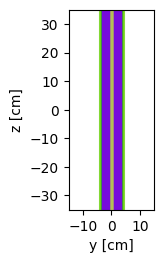

In [7]:
# Plotting fuel rod
root = model.geometry.root_universe
root.plot(width=(30, 70), origin=[0,0, 0], basis='yz')

An xy cut shows the reactor cell. The borders of the square have reflective boundary conditions:

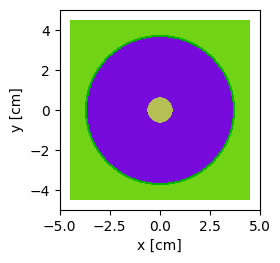

In [8]:
root.plot(width=(10, 10), origin=[0,0,0], basis='xy')

We can run it and obtain the infinite multiplication factor:

In [9]:
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
endf_results.append(sp.keff.nominal_value)
endf_error.append(sp.keff.std_dev)
endf_temps.append(293)

runtime = 14.34 s
keff = 1.3355+/-0.0014


We can change the temperature, create the model, and run again:

In [10]:
# 20% enriched uranium zirconium hydride fuel: 12 w% U + 88 w% ZrH2

uzrh = openmc.Material(name='UZrH')
uzrh.set_density('g/cm3', 6.128)
uzrh.add_nuclide('U235', 0.02376, 'wo')
uzrh.add_nuclide('U238', 0.09624, 'wo')
uzrh.add_element('H',    0.01902, 'wo')
uzrh.add_element('Zr',   0.86098, 'wo')
uzrh.temperature = 373 # K
uzrh.add_s_alpha_beta('c_H_in_ZrH')

model = create_model(uzrh)
model.export_to_xml()

In [11]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
endf_results.append(sp.keff.nominal_value)
endf_error.append(sp.keff.std_dev)
endf_temps.append(373)

runtime = 15.40 s
keff = 1.3283+/-0.0014


Here OpenMC is relying on the precomputed scattering kernels available within in the 'H(ZrH)' thermal scattering file. We can check the temperature values by accessing the file:

In [12]:
fn = '/home/student/tsl_software/endfb-viii.0-hdf5/neutron/c_H_in_ZrH.h5'
data = openmc.data.ThermalScattering.from_hdf5(fn)

In [13]:
data.temperatures

['1000K', '1200K', '296K', '400K', '500K', '600K', '700K', '800K']

For intermediate temperatures, OpenMC interpolates according to the parameters in `settings.temperature`. But, the limit of this interpolation is the range of nuclear data available in the library:

In [14]:
# 20% enriched uranium zirconium hydride fuel: 12 w% U + 88 w% ZrH2

uzrh = openmc.Material(name='UZrH')
uzrh.set_density('g/cm3', 6.128)
uzrh.add_nuclide('U235', 0.02376, 'wo')
uzrh.add_nuclide('U238', 0.09624, 'wo')
uzrh.add_element('H',    0.01902, 'wo')
uzrh.add_element('Zr',   0.86098, 'wo')
uzrh.temperature = 275 # K
uzrh.add_s_alpha_beta('c_H_in_ZrH')

model = create_model(uzrh)
model.export_to_xml()

In [15]:
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')

RuntimeError: Nuclear data library does not contain cross sections for c_H_in_ZrH at temperatures that bound 275 K.

## Developing a simple ZrH2 NCrystal model

We will start by loading the structure for ZrH2 from the Materials Project database. Access to Materials Project requires an API key. If it is not available, we have the CIF information as a backup for the example:

In [16]:
import os
os.environ['MATERIALSPROJECT_USER_API_KEY'] = 'my_32_character_key'
os.environ['NCRYSTAL_ONLINEDB_CACHEDIR'] = './ncrystal_onlinedb_filecache'

In [17]:
import NCrystal.cifutils as nccif
import NCrystal.plot as ncplot

try:
    cifsrc = nccif.CIFSource('mpid::24286')
except NC.NCException:
    print('Online DB not accessible, loading local data')
    cif_txt = '''
# generated using pymatgen
data_ZrH2
_symmetry_space_group_name_H-M   I4/mmm
_cell_length_a   3.527358434077031
_cell_length_b   3.527358434077031
_cell_length_c   4.414776315430252
_cell_angle_alpha   90.000000000000000
_cell_angle_beta   90.000000000000000
_cell_angle_gamma   90.000000000000000
_symmetry_Int_Tables_number   139
_chemical_formula_structural   ZrH2
_chemical_formula_sum   'Zr2 H4'
_cell_volume   54.929783820615413
_cell_formula_units_Z   2
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  'x, y, z'
  2  '-x, -y, -z'
  3  '-y, x, z'
  4  'y, -x, -z'
  5  '-x, -y, z'
  6  'x, y, -z'
  7  'y, -x, z'
  8  '-y, x, -z'
  9  'x, -y, -z'
  10  '-x, y, z'
  11  '-y, -x, -z'
  12  'y, x, z'
  13  '-x, y, -z'
  14  'x, -y, z'
  15  'y, x, -z'
  16  '-y, -x, z'
  17  'x+1/2, y+1/2, z+1/2'
  18  '-x+1/2, -y+1/2, -z+1/2'
  19  '-y+1/2, x+1/2, z+1/2'
  20  'y+1/2, -x+1/2, -z+1/2'
  21  '-x+1/2, -y+1/2, z+1/2'
  22  'x+1/2, y+1/2, -z+1/2'
  23  'y+1/2, -x+1/2, z+1/2'
  24  '-y+1/2, x+1/2, -z+1/2'
  25  'x+1/2, -y+1/2, -z+1/2'
  26  '-x+1/2, y+1/2, z+1/2'
  27  '-y+1/2, -x+1/2, -z+1/2'
  28  'y+1/2, x+1/2, z+1/2'
  29  '-x+1/2, y+1/2, -z+1/2'
  30  'x+1/2, -y+1/2, z+1/2'
  31  'y+1/2, x+1/2, -z+1/2'
  32  '-y+1/2, -x+1/2, z+1/2'
loop_
 _atom_site_type_symbol
 _atom_site_label
 _atom_site_symmetry_multiplicity
 _atom_site_fract_x
 _atom_site_fract_y
 _atom_site_fract_z
 _atom_site_occupancy
  Zr  Zr0  2  0.000000000000000  0.000000000000000
  0.000000000000000  1
  H  H1  4  0.000000000000000  0.500000000000000  0.250000000000000
  1

# Note from NCrystal.cifutils: Data from materialsproject.org / mp-24286
'''
    cifsrc = nccif.CIFSource(cif_txt)

This is the retrieved CIF file:

In [18]:
print( cifsrc.load_data() )

Getting mp_24286.cif from local file cache in $NCRYSTAL_ONLINEDB_CACHEDIR
# generated using pymatgen
data_ZrH2
_symmetry_space_group_name_H-M   I4/mmm
_cell_length_a   3.527358434077031
_cell_length_b   3.527358434077031
_cell_length_c   4.414776315430252
_cell_angle_alpha   90.000000000000000
_cell_angle_beta   90.000000000000000
_cell_angle_gamma   90.000000000000000
_symmetry_Int_Tables_number   139
_chemical_formula_structural   ZrH2
_chemical_formula_sum   'Zr2 H4'
_cell_volume   54.929783820615413
_cell_formula_units_Z   2
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  'x, y, z'
  2  '-x, -y, -z'
  3  '-y, x, z'
  4  'y, -x, -z'
  5  '-x, -y, z'
  6  'x, y, -z'
  7  'y, -x, z'
  8  '-y, x, -z'
  9  'x, -y, -z'
  10  '-x, y, z'
  11  '-y, -x, -z'
  12  'y, x, z'
  13  '-x, y, -z'
  14  'x, -y, z'
  15  'y, x, -z'
  16  '-y, -x, z'
  17  'x+1/2, y+1/2, z+1/2'
  18  '-x+1/2, -y+1/2, -z+1/2'
  19  '-y+1/2, x+1/2, z+1/2'
  20  'y+1/2, -x+1/2, -z+1/2'
  21  '-x+1/2

Now we load it and create an NCMATComposer object:

In [19]:
c_zrh = NC.NCMATComposer.from_cif(cifsrc)

Getting mp_24286.cif from local file cache in $NCRYSTAL_ONLINEDB_CACHEDIR
Attempting to load CIF data with gemmi
Self-consistency of structure was verified by spglib


In [20]:
print(c_zrh())

NCMAT v7
# Autogenerated by NCMATComposer
#
# H2Zr (tetragonal, SG-139)
#
# Atoms per unit cell: 4xH+2xZr
#
# Structure converted (with NCrystal.cifutils module) from:
#
#   The Materials Project
#   https://www.materialsproject.org/materials/mp-24286
#
# IMPORTANT NOTICE: This is a mostly automatic conversion which has not been
#                   verified!  In particular the @DYNINFO sections might need
#                   post-editing. Before distributing this file to other people,
#                   please review this, amend the comments here to document,
#                   anything done, and remove this notice.
#
# WARNING: Fallback (dummy) Debye temperature values were used for 2 atoms!
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  lengths 3.52736 !! 4.41478
  angles 90 90 90
@SPACEGROUP
  139
@ATOMPOSITIONS
  H 0 1/2 1/4
  H 0 1/2 3/4
  H 1/2 0 1/4
  H 1/2 0 3/4
  Zr 0 0 0
  Zr 1/2 1/2 1/2
@DYNINFO
  # WARNING: Using fallback Debye tem

The NCrystal model only contains a Debye Model that is incorrect for representing the vibration of hydrogen in ZrH2, because it is too simple to represent the vibrations of hydrogen: 

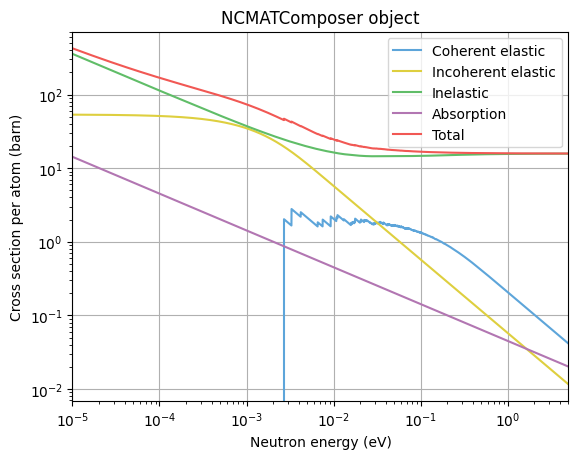

In [21]:
ncplot.plot_xsect(c_zrh, mode='ekin', xmin=1e-5, xmax=5)

We will replace this model with a vibrational density of states. We will add the VDOS data from the Keinert and Mattes model:

https://inis.iaea.org/collection/NCLCollectionStore/_Public/37/088/37088511.pdf

In [22]:
# H(ZrH) frequency spectra from Keinert and Mattes
vdos_txt = """
0.001 0.00154
0.002 0.00617
0.003 0.01387
0.004 0.02467
0.005 0.03854
0.006 0.05550
0.007 0.07554
0.008 0.09866
0.009 0.12490
0.010 0.15420
0.011 0.18650
0.012 0.22200
0.013 0.26050
0.014 0.30220
0.015 0.34690
0.016 0.39470
0.017 0.44550
0.018 0.49950
0.019 0.55650
0.020 0.61660
0.021 0.00000
0.022 0.00000
0.023 0.00000
0.024 0.00000
0.025 0.00000
0.026 0.00000
0.027 0.00000
0.028 0.00000
0.029 0.00000
0.030 0.00000
0.031 0.00000
0.032 0.00000
0.033 0.00000
0.034 0.00000
0.035 0.00000
0.036 0.00000
0.037 0.00000
0.038 0.00000
0.039 0.00000
0.040 0.00000
0.041 0.00000
0.042 0.00000
0.043 0.00000
0.044 0.00000
0.045 0.00000
0.046 0.00000
0.047 0.00000
0.048 0.00000
0.049 0.00000
0.050 0.00000
0.051 0.00000
0.052 0.00000
0.053 0.00000
0.054 0.00000
0.055 0.00000
0.056 0.00000
0.057 0.00000
0.058 0.00000
0.059 0.00000
0.060 0.00000
0.061 0.00000
0.062 0.00000
0.063 0.00000
0.064 0.00000
0.065 0.00000
0.066 0.00000
0.067 0.00001
0.068 0.00001
0.069 0.00001
0.070 0.00001
0.071 0.00001
0.072 0.00004
0.073 0.00007
0.074 0.00011
0.075 0.00014
0.076 0.00017
0.077 0.00020
0.078 0.00023
0.079 0.00026
0.080 0.00067
0.081 0.00144
0.082 0.00221
0.083 0.00298
0.084 0.00376
0.085 0.00453
0.086 0.00530
0.087 0.00608
0.088 0.00685
0.089 0.01793
0.090 0.02900
0.091 0.04008
0.092 0.05115
0.093 0.06223
0.094 0.07330
0.095 0.08438
0.096 0.09545
0.097 0.14760
0.098 0.24070
0.099 0.33390
0.100 0.42700
0.101 0.52020
0.102 0.61330
0.103 0.70650
0.104 0.79960
0.105 0.89280
0.106 1.11600
0.107 1.38400
0.108 1.70500
0.109 2.08600
0.110 2.53400
0.111 3.05700
0.112 3.66100
0.113 4.35300
0.114 5.14000
0.115 6.02700
0.116 7.01700
0.117 8.11200
0.118 9.31100
0.119 10.61000
0.120 12.01000
0.121 13.50000
0.122 15.06000
0.123 16.69000
0.124 18.36000
0.125 20.06000
0.126 21.76000
0.127 23.44000
0.128 25.07000
0.129 26.62000
0.130 28.07000
0.131 29.39000
0.132 30.55000
0.133 31.54000
0.134 32.33000
0.135 32.91000
0.136 33.26000
0.137 33.38000
0.138 33.26000
0.139 32.91000
0.140 32.33000
0.141 31.54000
0.142 30.55000
0.143 29.39000
0.144 28.07000
0.145 26.62000
0.146 25.06000
0.147 23.44000
0.148 21.76000
0.149 20.06000
0.150 18.36000
0.151 16.69000
0.152 15.06000
0.153 13.50000
0.154 12.01000
0.155 10.61000
0.156 9.31100
0.157 8.11200
0.158 7.01700
0.159 6.02700
0.160 5.14000
0.161 4.35300
0.162 3.66100
0.163 3.05700
0.164 2.53400
0.165 2.08600
0.166 1.70500
0.167 1.38400
0.168 1.11600
0.169 0.89280
0.170 0.72630
0.171 0.55980
0.172 0.45050
0.173 0.34120
0.174 0.27170
0.175 0.20210
0.176 0.15930
0.177 0.11640
0.178 0.09082
0.179 0.06519
0.180 0.00000
"""

Text(0, 0.5, 'rho [a.u.]')

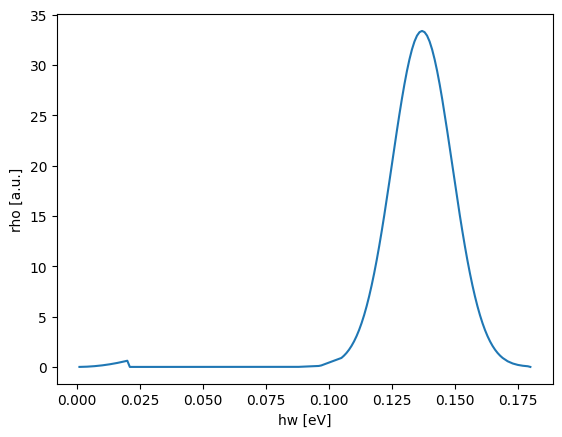

In [23]:
vdos_data = np.fromstring(vdos_txt, sep=' ')
vdos_data = np.reshape(vdos_data, (-1, 2))

plt.plot(vdos_data[:,0], vdos_data[:,1])
plt.xlabel('hw [eV]')
plt.ylabel('rho [a.u.]')

We need to find the hydrogen atoms in the NCMATComposer object, and replace their dynamic data with the VDOS:

In [24]:
c_zrh.set_dyninfo_vdos(c_zrh.find_label('H'), vdos_egrid=vdos_data[:,0], vdos=vdos_data[:,1])
print(c_zrh())

NCMAT v7
# Autogenerated by NCMATComposer
#
# H2Zr (tetragonal, SG-139)
#
# Atoms per unit cell: 4xH+2xZr
#
# Structure converted (with NCrystal.cifutils module) from:
#
#   The Materials Project
#   https://www.materialsproject.org/materials/mp-24286
#
# IMPORTANT NOTICE: This is a mostly automatic conversion which has not been
#                   verified!  In particular the @DYNINFO sections might need
#                   post-editing. Before distributing this file to other people,
#                   please review this, amend the comments here to document,
#                   anything done, and remove this notice.
#
# WARNING: Fallback (dummy) Debye temperature value was used for 1 atom!
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  lengths 3.52736 !! 4.41478
  angles 90 90 90
@SPACEGROUP
  139
@ATOMPOSITIONS
  H 0 1/2 1/4
  H 0 1/2 3/4
  H 1/2 0 1/4
  H 1/2 0 3/4
  Zr 0 0 0
  Zr 1/2 1/2 1/2
@DYNINFO
  element H
  fraction 2/3
  type vdos
 

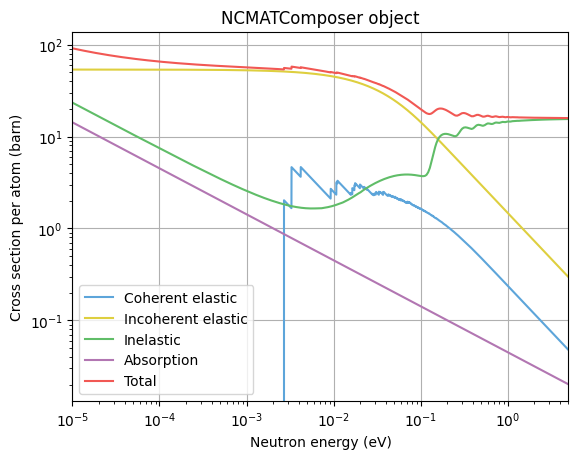

In [25]:
ncplot.plot_xsect(c_zrh, mode='ekin', xmin=1e-5, xmax=5)

Finally, we export an NCMAT file to provide to OpenMC:

In [26]:
c_zrh.write('zrh.ncmat')

PosixPath('zrh.ncmat')

## OpenMC model with NCrystal materials

We can create the U-ZrH2 material as a combination of our recently created NCMAT file, and an incoherent solid model for U:

In [27]:
info_zrh = NC.createInfo('zrh.ncmat')
dens_zrh = info_zrh.density
dens_umet = 19 # g/cm3

vf_zrh  = (0.88/dens_zrh)/((0.88/dens_zrh)+(0.12/dens_umet))  # Volume fraction for ZrH2
vf_umet = (0.12/dens_umet)/((0.88/dens_zrh)+(0.12/dens_umet)) # Volume fraction for U
cfg = f'phases<{vf_zrh}*zrh.ncmat&{vf_umet}*solid::U/{dens_umet}gcm3/U_is_0.20_U235_0.80_U238>;density=6.128gcm3'

With this configuration string we can create an OpenMC material object and plot it:

Text(0, 0.5, 'Macro XS [cm^-1]')

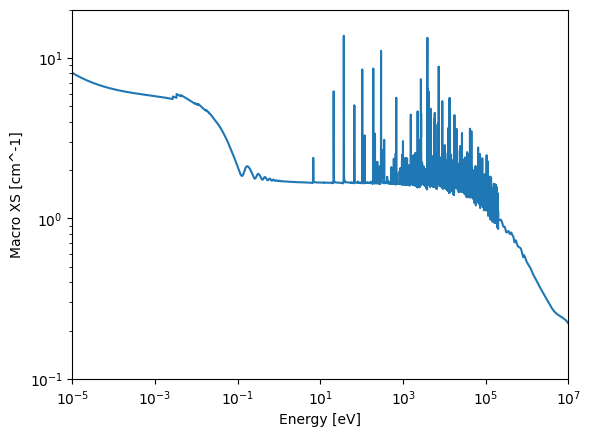

In [28]:
nc_uzrh = openmc.Material.from_ncrystal(cfg)
E, xs = openmc.calculate_cexs(nc_uzrh, ['scatter'])
plt.loglog(E,xs[0])
plt.xlim(1e-5, 10e6)
plt.ylim(0.1, 20)
plt.xlabel('Energy [eV]')
plt.ylabel('Macro XS [cm^-1]')

Again, we can run the system for the temperatures we ran before and compare with the results using ENDF data:

In [29]:
nc_uzrh = openmc.Material.from_ncrystal(cfg+';temp=293K')
model = create_model(nc_uzrh)
model.export_to_xml()

In [30]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
ncmat_results.append(sp.keff.nominal_value)
ncmat_error.append(sp.keff.std_dev)
ncmat_temps.append(293)

runtime = 26.87 s
keff = 1.3351+/-0.0016


In [31]:
nc_uzrh = openmc.Material.from_ncrystal(cfg+';temp=373K')
model = create_model(nc_uzrh)
model.export_to_xml()

In [32]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
ncmat_results.append(sp.keff.nominal_value)
ncmat_error.append(sp.keff.std_dev)
ncmat_temps.append(373)

runtime = 26.47 s
keff = 1.3289+/-0.0014


But, with the NCMAT file we are not limited in the temperature range:

In [33]:
nc_uzrh = openmc.Material.from_ncrystal(cfg+';temp=275K')
model = create_model(nc_uzrh)
model.export_to_xml()

In [34]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
ncmat_results.append(sp.keff.nominal_value)
ncmat_error.append(sp.keff.std_dev)
ncmat_temps.append(275)

runtime = 17.96 s
keff = 1.3374+/-0.0015


Text(0, 0.5, 'Multiplication factor')

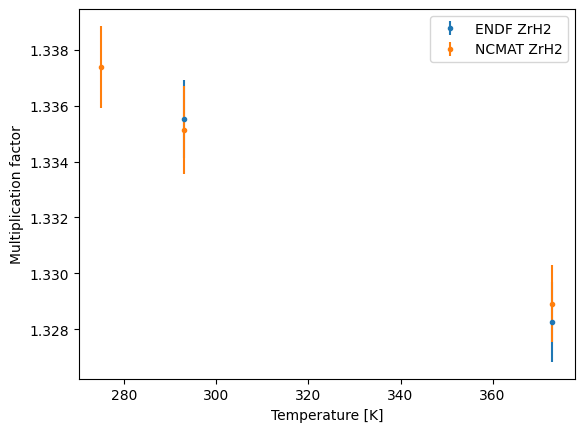

In [35]:
plt.errorbar(endf_temps, endf_results, yerr=endf_error, fmt='.', label='ENDF ZrH2')
plt.errorbar(ncmat_temps, ncmat_results, yerr=ncmat_error, fmt='.', label='NCMAT ZrH2')
plt.legend()
plt.xlabel('Temperature [K]')
plt.ylabel('Multiplication factor')